# Creating a General Purpose Potential for Molecular Crystals - Part 4

This notebook is used to create a general purpose GAP potential for molecular crystals. The potential is built on PBE-D3 data from short PIMD simulations of 2238 different molecular crystals. Please note that it has a high (~150 GB) memory requirement to run fully.

In this part of the notebook: 
- Tests...

### Import modules, functions, and necessary raw data from parts 1, 2 and 3

In [1]:
#Import modules
from matplotlib import pylab as plt
from tqdm import tqdm
import itertools
from joblib import Parallel, delayed, parallel_backend

import pickle
import numpy as np
from numpy.random import RandomState
random_state = RandomState(0)
from sklearn import linear_model
import skcosmo.feature_selection
#from skcosmo.feature_selection import FPS
from skcosmo.sample_selection import PCovCUR, FPS
from skcosmo.preprocessing import StandardFlexibleScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize, callbacks, dump, load
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence, plot_objective

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
# If installed -- not essential, though
try:
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = (lambda i, **kwargs: i)

from time import time, sleep

from rascal.models import KRR
from rascal.utils import dump_obj, load_obj

from rascal.models import Kernel, train_gap_model, compute_KNM
from rascal.representations import SphericalInvariants
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species
from rascal.utils import from_dict, to_dict, CURFilter, FPSFilter, dump_obj, load_obj
from rascal.utils import get_score, get_optimal_radial_basis_hypers
from rascal.utils.io import load_json, dump_json

In [5]:
#Import SOAP Bayesian optimisation modules
import sys  
sys.path.insert(0, '../code/SOAP-bayes/')
#from helpers import get_features_in_parallel, get_optimal_radial_basis_hypers_parallel
#from feature_skcosmo import atom_groups_by_frame

In [6]:
#Define functions
def do_fps(x, d=0):
    """
    Function for performing farthest-point-sampling for a given feature matrix.
    d gives the number of farthest-point-sampled feature vectors that will be outputted. 
    If d==0, the entire set will be FPS-sorted.
    Returns the FPS-sorted IDs, as well as the FPS distances.
    """
    if d == 0 : d = len(x)
    n = len(x)
    iy = np.zeros(d, int)
    # faster evaluation of Euclidean distance
    n2 = np.sum(x**2,axis=1)
    iy[0] = 0
    dl = n2 + n2[iy[0]] - 2* np.dot(x, x[iy[0]])
    dss = []
    for i in range(1,d):
        iy[i] = np.argmax(dl)
        nd = n2 + n2[iy[i]] - 2*np.dot(x,x[iy[i]])
        dl = np.minimum(dl, nd)
        dss.append(max(dl))
    return iy,dss

def get_forces(frames):
    frc = np.zeros((np.sum([len(frm) for frm in frames]),3))
    iat = 0
    for ifrm,frm in enumerate(frames):
        frc[iat:iat+len(frm)] = frm.get_array('forces') 
        iat += len(frm)
    return frc

def get_features(atoms_objects, batch_size=1000, progress_bar=True):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        This requires soap to be set.
    '''
    struct_feat=[] #create empty feature vector of n_structures x n_features
    got_frame = False
    for frm in atoms_objects:
        if got_frame == False: 
            if all(sp in frm.get_atomic_numbers() for sp in [1,6,7,8]) == True:
                all_species = frm
                got_frame = True
    for i in tqdm(range(int(len(atoms_objects)/batch_size+0.9999)), disable = not progress_bar): #Get feature vectors in batches of 1000
        for frm in atoms_objects[i*batch_size:(i+1)*batch_size]:
            frm.wrap(eps=1e-13) #wrap atoms in unit cell
        frames=[all_species.copy()] #add initial frame with all species
        frames.extend(atoms_objects[i*batch_size:(i+1)*batch_size]) #extend initial frame with frames of batch
        manager = soap.transform(frames) #calculate soap features for all structures in batch
        env_feat_batch = manager.get_features(soap)[len(all_species):] #get feature vectors for all structures in batch
        # (having removed the initial frame)
        atom_counter=0 #count atoms
        for ifrm,frm in enumerate(atoms_objects[i*batch_size:(i+1)*batch_size]): #iterate over frames in batch
            nat=len(frm) #count atoms in frame
            struct_feat.append(np.mean(env_feat_batch[atom_counter:atom_counter+nat],axis=0)) #average vectors
            # for atoms in the same frame. Done by averaging vectors between atom_counter and atom_counter + nat
            atom_counter+=nat #add atoms to counter
    struct_feat_array=np.asarray(struct_feat)
    return struct_feat_array

def get_features_parallel(atoms_objects, bsize=1000, n_cores = 4):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        Do this in parallel
    '''
    blocks = []
    for iblk, blk in enumerate(range(0, len(atoms_objects), bsize)):
        blocks.append(atoms_objects[iblk*bsize:(iblk+1)*bsize])
    with parallel_backend(backend="loky"):
        results = Parallel(n_jobs=n_cores)(delayed(get_features)(frames, batch_size=10000, 
                                                                 progress_bar=False) for frames in blocks)

    return np.concatenate(results)

def predict_batched(frames, ml_model):
    man_pred = soap.transform(frames)
    return ml_model.predict(man_pred)

In [7]:
#Import raw data
train_set = np.load('raw_data/CSD-10k_train_set.npy', allow_pickle=True)
val_set = np.load('raw_data/CSD-10k_val_set.npy', allow_pickle=True)
test_set = np.load('raw_data/CSD-10k_test_set.npy', allow_pickle=True)
X_train = np.load('raw_data/X_train.npy') 
y_train = np.load('raw_data/y_train.npy')
X_val = np.load('raw_data/X_val.npy') 
y_val = np.load('raw_data/y_val.npy')
X_test = np.load('raw_data/X_test.npy') 
y_test = np.load('raw_data/y_test.npy')
X_train_fps = np.load('raw_data/X_train_fps.npy')
y_train_fps = np.load('raw_data/y_train_fps.npy')
fps_ids = np.load('raw_data/CSD-10k_train_set_FPS_ids.npy')
fps_dist = np.load('raw_data/CSD-10k_train_set_FPS_dist.npy')
with open('raw_data/mlr.pkl', 'rb') as mlr_file:
    mlr = pickle.load(mlr_file)
initial_train_set = np.load('raw_data/initial_train_set_4pc.npy', allow_pickle=True)
train_set_FPS = np.load('model_data/train_set_FPS.npy', allow_pickle=True)

/home/vprincip/code/miniconda3/envs/genshift/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Ridge from version 1.1.0rc1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Compute necessary data and define SOAP

In [8]:
#Compute training, validation and testing data
#Get training data for the FPS-sorted training set
ytF = []
for ifrm, frm in enumerate(train_set_FPS):
    ytF.append(frm.info['energy'])
ytrain_FPS = np.array(ytF)

#Get true energies and forces for validation set
yvt = []
fvt = []

for frm in val_set:
    yvt.append(frm.info['energy'])
    fvt.append(frm.get_array('forces'))

yval_true = np.array(yvt)
fval_true = np.concatenate(fvt)

#Get true energies and forces for test set
ytt = []
ftt = []

for frm in test_set:
    ytt.append(frm.info['energy'])
    ftt.append(frm.get_array('forces'))

ytest_true = np.array(ytt)
ftest_true = np.concatenate(ftt)

#get dressed atom energies for reduced training set
y_dressed = {}
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]

In [9]:
#Define hyperparameters and SOAP
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False 
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

## Test without gradients
Model seems to perform poorly with not much explanation why... should try and recreate model using `compute_gradients = False ` 

In [ ]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
soap = SphericalInvariants(**hypers)

In [ ]:
#get features
start = time()
print("Calculating features...")
train_set_FPS_feats = soap.transform(train_set_FPS)
print("Time taken =", time()-start)

In [ ]:
#Define kernel
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [ ]:
start = time()
print("Computing kernel...")
Knm = kernel(train_set_FPS_feats, X_sparse_FPS)
print("Time taken = ", time()-start)

In [ ]:
#Save kernel
np.save('model_data/Knm_kernel_no_grad', Knm)

In [ ]:
Knm = np.load('model_data/Knm_kernel_no_grad.npy')

In [ ]:
#Train GAP model
y_dressed = {} #create dressed atom energies for reduced training set
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_FPS, Knm, X_sparse_FPS, ytrain_FPS, y_dressed, 
                        grad_train=None, lambdas=[0.1, 1], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken :", time()-start)

In [ ]:
hypers["compute_gradients"] = True
soap = SphericalInvariants(**hypers)

In [ ]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for frm in tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)

In [ ]:
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(fval_true.flatten()[:npred], fval_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

In [ ]:
f,p = plt.subplots(1,2,figsize=(12,5))
p[0].hist(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2)
p[0].set_title('Distr. of Squared Energy Error')
p[0].set_yscale('log')
p[1].hist((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2)
p[1].set_title('Distr. of Squared Forces Error')
p[1].set_yscale('log')

In [ ]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [ ]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [ ]:
print(rmse_energy, rmse_forces) #0.1, 1 lambas

## Test by using FPS-sorted configurations
It seems like the PCovCUR-selected configurations (8400 total) has 4807 original structures and 3593 dupicates. The first dupicate occurred after 2678 selections. This occurred even though `recompute_every` was set to 1 for the first 3000 selections, and the SOAP vector has a length of 5670.
I will therefore try and use FPS-sorted structures for the model and recompute

In [10]:
#Redefine hyperparameters and SOAP
hypers["compute_gradients"] = False
soap = SphericalInvariants(**hypers)

In [11]:
ntrain = 8400

In [ ]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set_FPS[:ntrain]) #calculating features
print("Time taken: ", time()-start, "s")

In [ ]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 1778
nc = 1467
nn = 1467
no = 1778
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse_FPS = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

In [ ]:
dump_obj('model_data/X_sparse_FPS.json', X_sparse_FPS)

In [12]:
X_sparse_FPS = load_obj('model_data/X_sparse_FPS.json')

KeyboardInterrupt: 

In [17]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [ ]:
#Compute kernel
start=time()
Knm_FPS = compute_KNM(tqdm(train_set_FPS[:ntrain], desc="Compute KNM", leave=False), X_sparse_FPS, kernel, soap)
print("Time taken: ", time()-start, "s")

In [ ]:
#Save kernel
np.save('model_data/Knm_kernel_FPS', Knm_FPS)

In [ ]:
Knm_FPS = np.load('model_data/Knm_kernel_FPS.npy')

In [ ]:
#Train GAP model
y_dressed = {} #create dressed atom energies for reduced training set
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm_FPS, X_sparse_FPS, ytrain_FPS[:ntrain], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken:", time()-start)

In [ ]:
dump_obj('model_data/full_GAP_model_FPS_0.055_3.25.json', full_model)

In [29]:
full_model = load_obj('model_data/full_GAP_model_FPS_0.1_1.json')

### Predict on validation set

In [ ]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for frm in tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)

In [ ]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(fval_true.flatten()[:npred], fval_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

In [ ]:
#Plot distribution of energy and force errors
f,p = plt.subplots(1,2,figsize=(12,5))
p[0].hist(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2)
p[0].set_title('Distr. of Squared Energy Error')
p[0].set_yscale('log')
p[1].hist((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2)
p[1].set_title('Distr. of Squared Forces Error')
p[1].set_yscale('log')

In [ ]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [ ]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [ ]:
print(rmse_energy, rmse_forces)

### Predict on test set

In [30]:
#predict energies and forces for test set
npred=1000
ytp = []
ftp = []

for frm in tqdm(test_set[:npred], desc = "Making predictions for validation set...", leave=False):
    manager_test = soap.transform(frm)
    ytp.append(full_model.predict(manager_test))
    ftp.append(full_model.predict_forces(manager_test))

ytest_pred = np.array(ytp).flatten()
ftest_pred = np.concatenate(ftp)

Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

In [31]:
ytest_pred = np.array(ytp).flatten()
ftest_pred = np.concatenate(ftp)

Text(0, 0.5, 'Predicted force (ev / $\\AA$)')

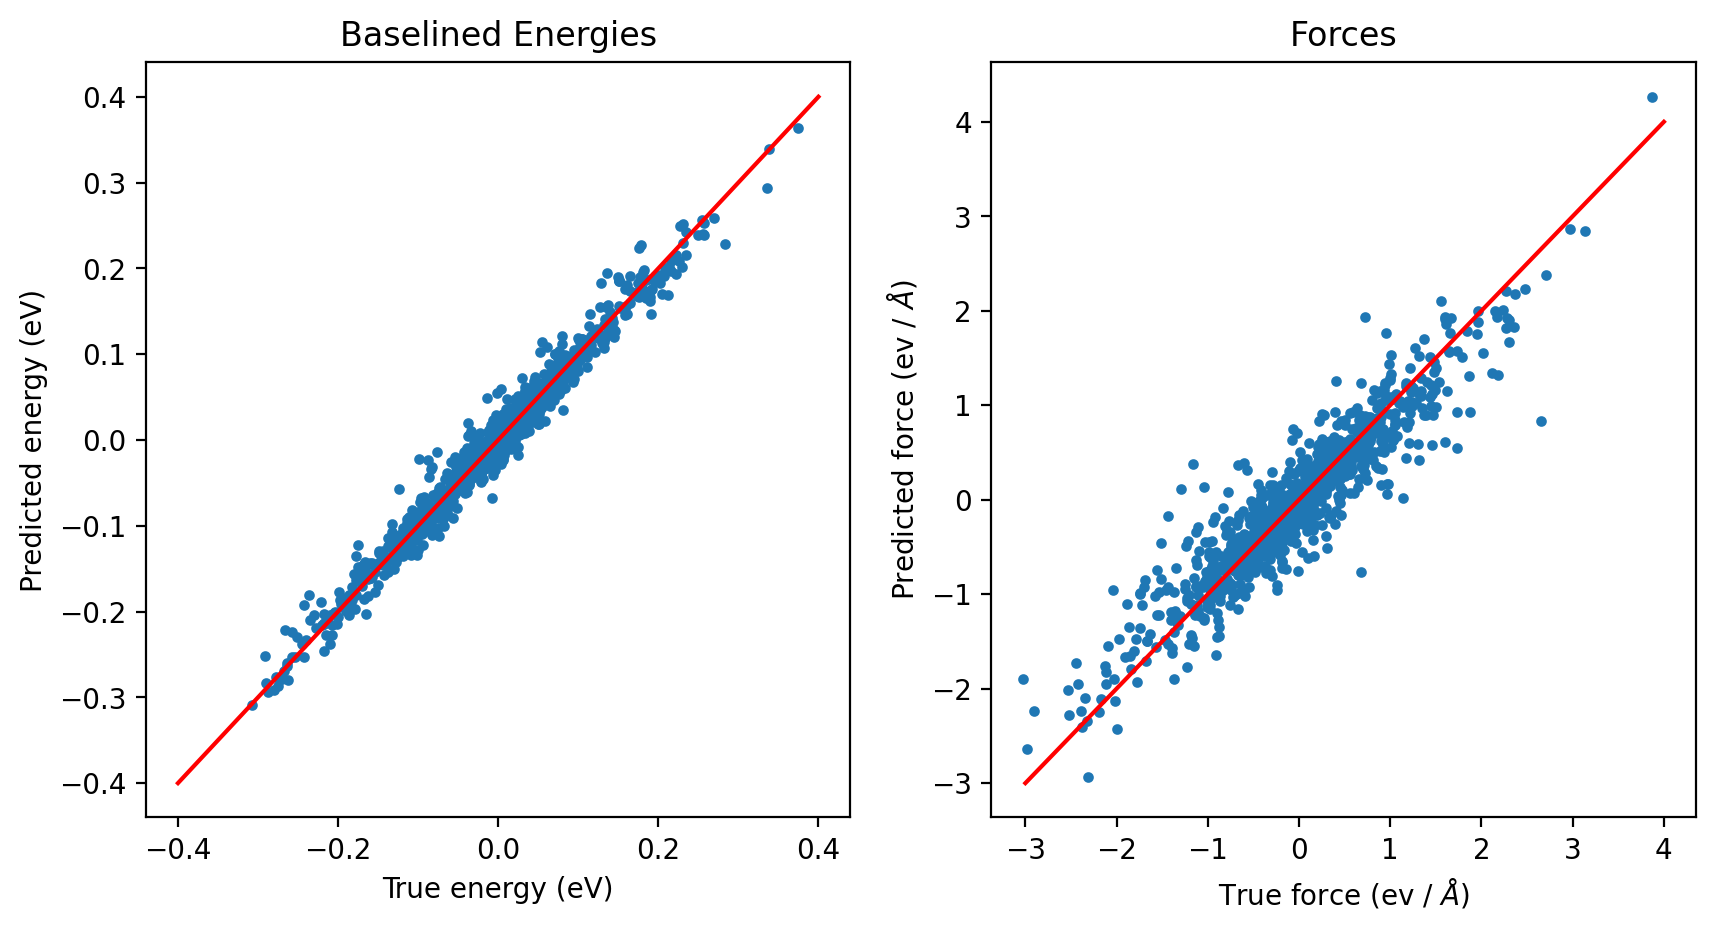

In [32]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5), dpi=200)
p[0].scatter((ytest_true[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1),
             (ytest_pred[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1), s=8)
p[0].plot([-0.4,0.4],[-0.4, 0.4], color='red')
p[0].set_title(r'Baselined Energies')
p[0].set_xlabel('True energy (eV)')
p[0].set_ylabel('Predicted energy (eV)')
p[1].scatter(ftest_true.flatten()[:npred], ftest_pred.flatten()[:npred], s=8)
p[1].plot([-3,4],[-3, 4], color='red')
p[1].set_title(r'Forces')
p[1].set_xlabel('True force (ev / $\AA$)')
p[1].set_ylabel('Predicted force (ev / $\AA$)')

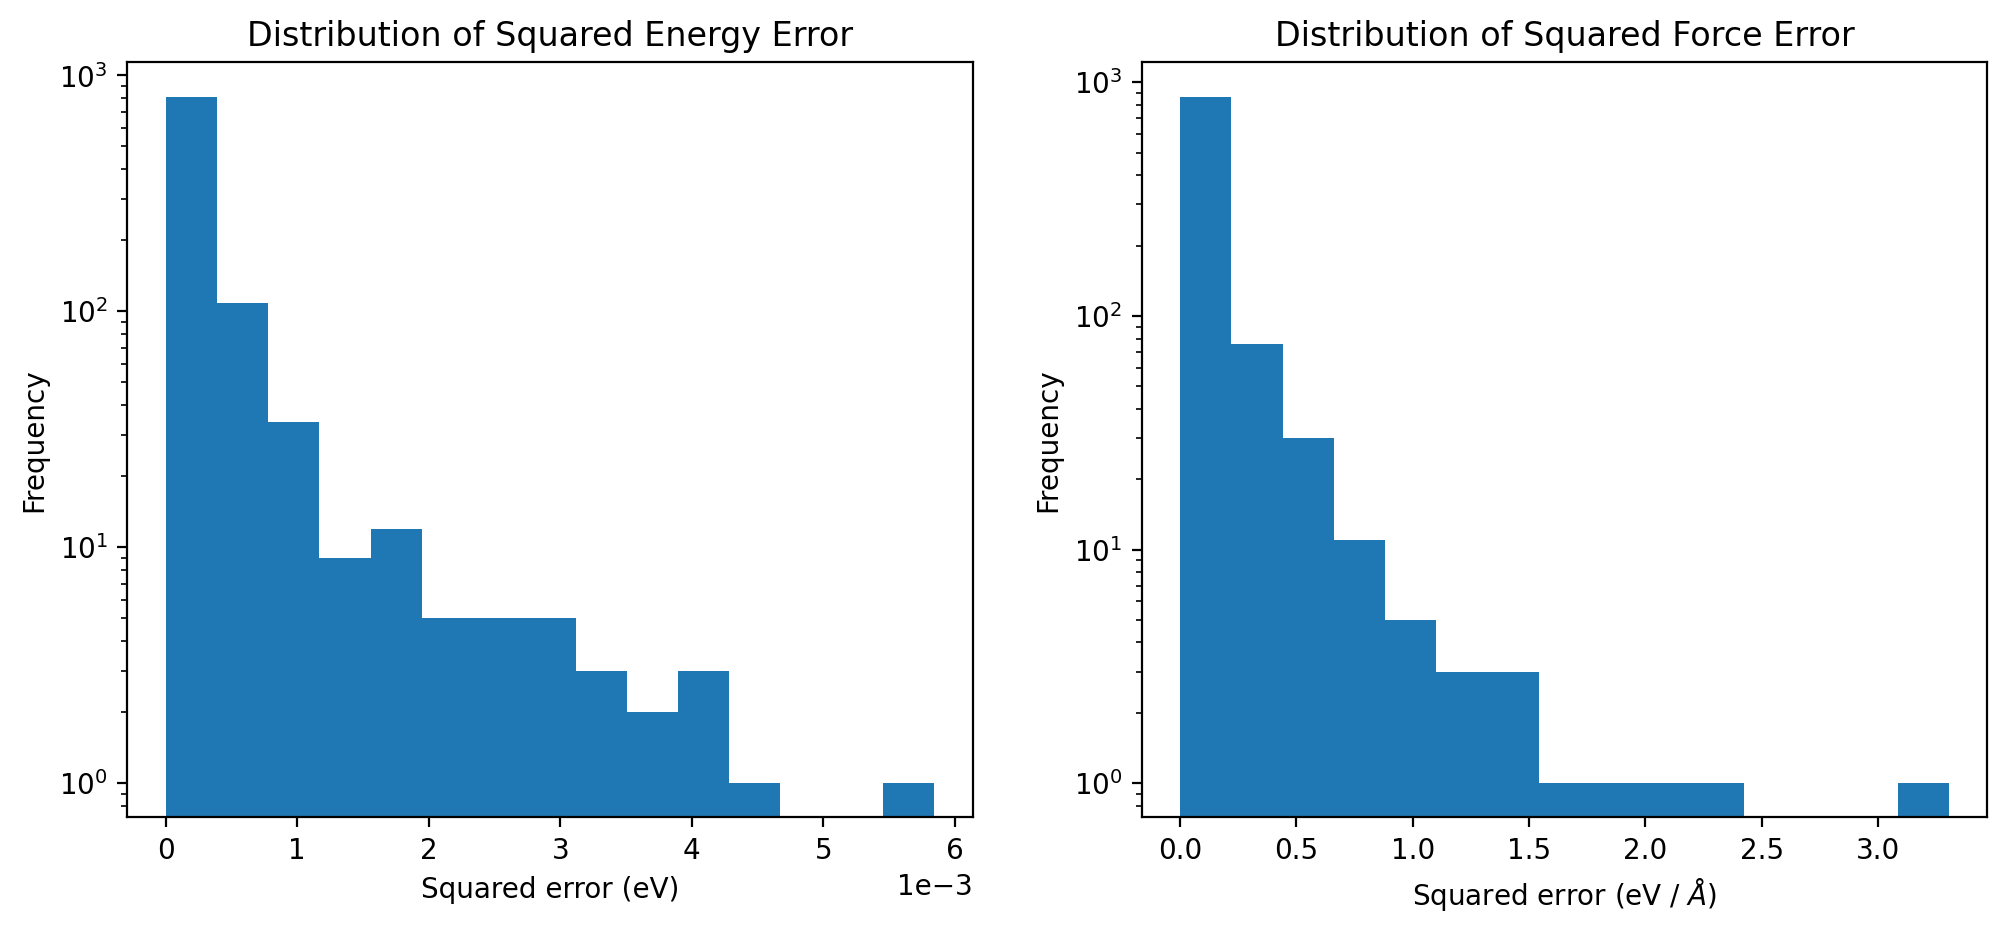

In [33]:
#Plot distribution of energy and force errors
f,p = plt.subplots(1,2,figsize=(12,5), dpi=200)
p[0].hist(((ytest_true[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1) 
           - (ytest_pred[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1))**2, bins=15)
p[0].set_title('Distribution of Squared Energy Error')
p[0].set_yscale('log')
p[0].set_xlabel('Squared error (eV)')
p[0].set_ylabel('Frequency')
p[0].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
p[1].hist((ftest_true.flatten()[:npred] - ftest_pred.flatten()[:npred])**2, bins=15)
p[1].set_title('Distribution of Squared Force Error')
p[1].set_xlabel('Squared error (eV / $\AA$)')
p[1].set_ylabel('Frequency')
p[1].set_yscale('log')

In [34]:
rmse_energy = np.sqrt(np.mean(
    ((ytest_true[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1) 
     - (ytest_pred[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1))**2))

In [35]:
rmse_forces = np.sqrt(np.mean((ftest_true.flatten()[:npred] - ftest_pred.flatten()[:npred])**2))

In [36]:
print("RMSE energy: ", np.round(rmse_energy, 8)*1000, "meV/atom")
print("RMSE forces: ", np.round(rmse_forces, 5)*1000, "meV/Angstrom")

RMSE energy:  16.82326 meV/atom
RMSE forces:  324.25 meV/Angstrom


In [ ]:
#RMSE for 0.055 3.25 reg model

In [28]:
print("RMSE energy: ", np.round(rmse_energy, 8)*1000, "meV/atom")
print("RMSE forces: ", np.round(rmse_forces, 5)*1000, "meV/Angstrom")

RMSE energy:  6.89516 meV/atom
RMSE forces:  378.49 meV/Angstrom


### Optimise regularization parameters

In [ ]:
#Loop for optimising regularization parameters
npred=100
for er in np.linspace(0.01, 0.1, 5):
    for fr in np.linspace(1, 10, 5):
        print("Testing for energy reg", er, "and force reg", fr)
        start=time()
        full_model = train_gap_model(kernel, train_set_FPS, Knm_FPS, X_sparse_FPS, ytrain_FPS, y_dressed, 
                        grad_train=-get_forces(train_set_FPS), lambdas=[er,fr], jitter=1e-9, 
                        solver = 'RKHS')
        yvp = []
        fvp = []
        for frm in tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False):
            manager_val = soap.transform(frm)
            yvp.append(full_model.predict(manager_val))
            fvp.append(full_model.predict_forces(manager_val))

        yval_pred = np.array(yvp).flatten()
        fval_pred = np.concatenate(fvp)
        rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))
        rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))
        print("Energy RMSE:", rmse_energy, "  Force RMSE:", rmse_forces, "   Time taken:", time()-start)

## Pseudo-active learning curve for FPS-selected structures

In [ ]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
soap = SphericalInvariants(**hypers)

In [ ]:
train_set_FPS_feats = get_features(train_set_FPS)

In [ ]:
val_feat = get_features(val_set)

In [ ]:
X_train_FPS = np.zeros((len(train_set_FPS),4),dtype=int)
y_train_FPS = np.zeros(len(train_set_FPS))
for ifrm, frm in enumerate(train_set_FPS):
    symbols=frm.get_atomic_numbers()
    y_train_FPS[ifrm]=(frm.info['energy'])
    X_train_FPS[ifrm]=[len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]

In [ ]:
yred_train_FPS = y_train_FPS/np.sum(X_train_FPS,axis=1)-mlr.predict(X_train_FPS)/np.sum(X_train_FPS,axis=1)

In [ ]:
structures = []
errors = []
for nstruct in [2000,4000,8000,12000,16000,20000,22617]:
    K = np.dot(train_set_FPS_feats[:nstruct], train_set_FPS_feats[:nstruct].T)**zeta #compute kernel matrix for training
    Kval = np.dot(val_feat,train_set_FPS_feats[:nstruct].T)**zeta #compute kernel matrix for validation
    KRR = KernelRidge(kernel='precomputed',alpha = 1e-9)
    KRR.fit(K,yred_train_FPS[:nstruct])
    err = np.std((yval_true - mlr.predict(X_val))/np.sum(X_val, axis=1) - KRR.predict(Kval))
    print(nstruct, err)
    structures.append(nstruct)
    errors.append(err)

In [ ]:
#Plot
plt.plot(structures,errors)
plt.xscale('log')
plt.yscale('log')

## Test with more structures
From the above test, it seems like the learning curve is not saturated at 8400 structures. More than that, it is likely that more structures are required to saturate the learning curve for forces than for energies. The reason for this is likely because, as Edgar put it, "the structural variance in local atomic environments is larger than that in structures (where differences between constituent environments are to some degree averaged out), and energies are a structural property whereas forces are an environmental one."

In [13]:
ntrain = 12000

In [ ]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
soap = SphericalInvariants(**hypers)

In [ ]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set_FPS[:ntrain]) #calculating features
print("Time taken: ", time()-start, "s")

In [ ]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 1778
nc = 1467
nn = 1467
no = 1778
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse_FPS = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

In [ ]:
dump_obj('raw_data/X_sparse_12k.json', X_sparse_FPS)

In [14]:
X_sparse_FPS = load_obj('raw_data/X_sparse_12k.json')

FileNotFoundError: [Errno 2] No such file or directory: '/home/vprincip/general_potential/raw_data/X_sparse_12k.json'

In [ ]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [ ]:
#Compute kernel
start=time()
Knm_FPS = compute_KNM(tqdm(train_set_FPS[:ntrain], desc="Compute KNM", leave=False), X_sparse_FPS, kernel, soap)
print("Time taken: ", time()-start, "s")

In [ ]:
#Save kernel
np.save('raw_data/Knm_kernel_12k', Knm_FPS)

In [15]:
Knm_FPS = np.load('raw_data/Knm_kernel_12k.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'raw_data/Knm_kernel_12k.npy'

In [ ]:
#Train GAP model
y_dressed = {} #create dressed atom energies for reduced training set
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm_FPS, X_sparse_FPS, ytrain_FPS, y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken:", time()-start)

In [ ]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for frm in tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)

In [ ]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(fval_true.flatten()[:npred], fval_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

In [ ]:
#Plot distribution of energy and force errors
f,p = plt.subplots(1,2,figsize=(12,5))
p[0].hist(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2)
p[0].set_title('Distr. of Squared Energy Error')
p[0].set_yscale('log')
p[1].hist((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2)
p[1].set_title('Distr. of Squared Forces Error')
p[1].set_yscale('log')

In [ ]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [ ]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [ ]:
print(rmse_energy, rmse_forces)

## Test with more sparse points
For the same reasoning as no. of structures, it might be better to increase the number of sparse points per species in order to improve force predictions.

In [ ]:
ntrain = 8400

In [ ]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
soap = SphericalInvariants(**hypers)

In [ ]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set_FPS[:ntrain]) #calculating features
print("Time taken: ", time()-start, "s")

In [ ]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 2500
nc = 2500
nn = 2500
no = 2500
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse_FPS = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

In [ ]:
dump_obj('raw_data/X_sparse_2500_ps.json', X_sparse_FPS)

In [ ]:
X_sparse_FPS = load_obj('raw_data/X_sparse_2500_ps.json')

In [ ]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [ ]:
#Compute kernel
start=time()
Knm_FPS = compute_KNM(tqdm(train_set_FPS[:ntrain], desc="Compute KNM", leave=False), X_sparse_FPS, kernel, soap)
print("Time taken: ", time()-start, "s")

In [ ]:
#Save kernel
np.save('raw_data/Knm_kernel_2500_ps', Knm_FPS)

In [ ]:
Knm_FPS = np.load('raw_data/Knm_kernel_2500_ps.npy')

In [ ]:
#Train GAP model
y_dressed = {} #create dressed atom energies for reduced training set
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm_FPS, X_sparse_FPS, ytrain_FPS[:ntrain], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken:", time()-start)

In [ ]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))
    if ifrm % 100 == 0:
        print(ifrm)

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)

In [ ]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(fval_true.flatten()[:npred], fval_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

In [ ]:
#Plot distribution of energy and force errors
f,p = plt.subplots(1,2,figsize=(12,5))
p[0].hist(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2)
p[0].set_title('Distr. of Squared Energy Error')
p[0].set_yscale('log')
p[1].hist((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2)
p[1].set_title('Distr. of Squared Forces Error')
p[1].set_yscale('log')

In [ ]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [ ]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [ ]:
print(rmse_energy, rmse_forces)

## Effect of sparse points on GAP accuracy

From above, we can see that the errors using 2500 sparse points per species are:
- 5.1 meV for energy predictions
- 349 meV for force predictions

Using the "standard number of sparse points (~1600 per species), the errors are:
- 6.5 meV for energy predictions
- 440 meV for force predictions

We will now try and reduce the number of sparse points further to see the effect it has on the accuracy of predictions. If we can obtain similar accuracy with fewer sparse points this would lighten the model.

In [ ]:
ntrain = 8400

In [ ]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
soap = SphericalInvariants(**hypers)

In [ ]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set_FPS[:ntrain]) #calculating features
print("Time taken: ", time()-start, "s")

In [ ]:
#Loop for testing dependency of number of sparse points on GAP model accuracy
rmses = np.zeros((3,3))
for ins, ns in enumerate([700, 1000, 1300]):
    print("Testing for ", ns, "sparse points per species")
    start=time()
    #Define hyperparameters and SOAP
    hypers["compute_gradients"] = False
    soap = SphericalInvariants(**hypers)
    
    #Calculate X_sparse
    nsparse    = {1: ns, 6: ns, 7: ns, 8: ns} #Select number of sparse environemnts per species
    compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
    print("Sparsifying training set...")
    X_sparse_FPS = compressor.select_and_filter(manager_train) #Apply filter to training set
    
    #Define kernel and redefine hypers 
    hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
    soap = SphericalInvariants(**hypers)
    kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel
    
    #Compute kernel
    print("Computing kernel...")
    Knm_FPS = compute_KNM(tqdm(train_set_FPS[:ntrain], desc="Computing KNM", leave=False), X_sparse_FPS, kernel, soap)
    
    #Train model
    print("Training model...")
    full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm_FPS, X_sparse_FPS, ytrain_FPS[:ntrain], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
    
    #predict energies and forces for validation set
    npred=1000
    yvp = []
    fvp = []
    
    print("Making predictions on validation set...")
    for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
        manager_val = soap.transform(frm)
        yvp.append(full_model.predict(manager_val))
        fvp.append(full_model.predict_forces(manager_val))

    yval_pred = np.array(yvp).flatten()
    fval_pred = np.concatenate(fvp)
    
    #get energy and force rmses
    rmse_energy = np.sqrt(np.mean(
        ((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) 
         - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))
    rmse_force = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))
    
    print("For", nsparse, "sparse points per species :")
    print("Energy RMSE:", rmse_energy)
    print("Force RMSE:", rmse_force)
    print("Total time taken for full test:", time()-start)
    
    #Append info to numpy array
    rmses[ins] = [ns, rmse_energy, rmse_force]

#Save results
np.save('raw_data/sparse_points_test', rmses)
print(rmses)

In [ ]:
print(rmses)

In [ ]:
np.save('raw_data/sparse_points_test', rmses)

## Effect of SOAP vector size on GAP accuracy

The large SOAP vector of 5670 severely reduces the speed of predictions, and so we will try and see how the accuracy of predictions is dependent on the size of the SOAP vector.

We will first try and use Bayesian hyperparameter optimisation to see if we can get good results using a smaller vector (and to see if we can improve results significantly using this Bayesian optimisation).

(We will reduce the SOAP vector to size 2520 by using nmax = 6 and lmax =6.

We will then reduce it to size 1800 by using nmax = 6 and lmax = 4.)

### Bayesian optimisation of hyperparameters

In [ ]:
ntrain = 8400

In [ ]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
hypers["interaction_cutoff"] = 4
hypers["max_radial"] = 6
hypers["max_angular"] = 6
soap = SphericalInvariants(**hypers)

In [ ]:
X_train_FPS = np.zeros((len(train_set_FPS),4),dtype=int)
y_train_FPS = np.zeros(len(train_set_FPS))
for ifrm, frm in enumerate(train_set_FPS):
    symbols=frm.get_atomic_numbers()
    y_train_FPS[ifrm]=(frm.info['energy'])
    X_train_FPS[ifrm]=[len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]

In [ ]:
train_structures = train_set_FPS[:10000]
test_structures = val_set.copy()
y_train = y_train_FPS[:10000]-mlr.predict(X_train_FPS[:10000])

In [ ]:
#define a searchspace
space = [Real(10**-6, 10**1, "log-uniform", name='alpha'),
        Real(1.0,3.0, "uniform", name="scale"),
        Real(3.0,7.0, "uniform", name="interaction_cutoff"),
        Real(0.05,0.6, "uniform", name="gaussian_sigma_constant"),
        Real(0.1,20.0, "uniform", name="exponent"),
        Real(0.1,20.0, "uniform", name="rate")
        ]

In [ ]:
#define the SOAP objective
feature_gen_time = 0
hyper_opt_time = 0
model_fit_time = 0


@use_named_args(space)
def soap_objective(**params):
    global feature_gen_time
    global hyper_opt_time
    global model_fit_time
    
    new_params = params.copy()
    new_hypers = hypers.copy()
    
    #modify SOAP hypers
    new_hypers["interaction_cutoff"] = new_params["interaction_cutoff"]
    new_hypers["gaussian_sigma_constant"] = new_params["gaussian_sigma_constant"]
    new_hypers["cutoff_function_parameters"] = {"rate":new_params["rate"],
                                               "exponent":new_params["exponent"],
                                               "scale":new_params["scale"]}
    soap = SphericalInvariants(**new_hypers)
    
    #obtain optimal radial basis
    start_time = time()
    new_hypers = get_optimal_radial_basis_hypers_parallel(new_hypers,train_structures,num_cores=-1,
                                                          expanded_max_radial=20)
    hyper_opt_time += time() - start_time
    
    #update model parameters
    model.set_params(alpha=new_params["alpha"])
    
    #calculate SOAP features
    start_time = time()
    X_train = get_features_parallel(train_structures, bsize=200, n_cores=60)
    feature_gen_time += time() - start_time
    
    #Model training and scoring
    start_time = time()
    #in production it might make sense to increase the k-fold to 5, given that bayes opt makes the noise free asummption
    #splits = list(GroupKFold(n_splits=3).split(X_train,y_train)
    score = -np.mean(cross_val_score(model, X_train, y_train, n_jobs=-1,
                                    scoring="neg_mean_squared_error"))
    model_fit_time += time() - start_time
    print("--eval--")
    
    #return n-fold cross val
    return score


In [ ]:
#Perform Bayseian hyperparameter optimisation
feature_gen_time = 0
hyper_opt_time = 0
model_fit_time = 0

model = Ridge()

# We provide a reasonable first guess.
# Parameters reported in 10.1039/C9CP04489B Engel et al.  
# model alpha, scale, cutoff, sigma, exponent, rate
reasonable_guess = [1e-05,2.0,4.5,0.3,3,1]

checkpoint_saver = CheckpointSaver("./checkpoint_solver.pkl", compress=9)

print("starting")
start_time_total = time()

# provide search space, number of total objective function calls, a sead, an initial guess (optional)
# the number of jobs to optimize the aquisition function (LBFGS) and a callback (checkpoint saver)

#---------- actual optimization is called here -------------

res_gp = gp_minimize(soap_objective, space, n_calls=100, random_state=0,\
                     x0=reasonable_guess, n_jobs=-1, callback=[checkpoint_saver])

#------------------------------------------------------------

print("--- 25 steps took %.0f seconds ---" % (time() - start_time_total))
print("--- feature generation took %.0f seconds ---" % (feature_gen_time))
print("--- model fitting took %.0f seconds ---" % (model_fit_time))
print("--- hyper optimization took %.0f seconds ---" % (hyper_opt_time))

dump(res_gp, "solver_final.pkl")

print("finished")

In [ ]:
plt.figure(dpi=150,figsize=(5.,3.))
_ = plot_convergence(res_gp)

In [ ]:
#we can also load the last OptimizeResult
res_gp = load("checkpoint_solver.pkl")

In [ ]:
# model alpha, scale, cutoff, sigma, exponent, rate
res_gp.x

In [ ]:
# model alpha, scale, cutoff, sigma, exponent, rate
hypers["interaction_cutoff"] = res_gp.x[2]
hypers["gaussian_sigma_constant"] = res_gp.x[3]
hypers["cutoff_function_parameters"] = {"rate":res_gp.x[5],
                                               "exponent":res_gp.x[4],
                                               "scale":res_gp.x[1]}

In [ ]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
soap = SphericalInvariants(**hypers)

In [ ]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set_FPS[:ntrain]) #calculating features
print("Time taken: ", time()-start, "s")

In [ ]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 1300
nc = 1300
nn = 1300
no = 1300
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse_FPS = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

In [ ]:
dump_obj('raw_data/X_sparse_bayes_hypers.json', X_sparse_FPS)

In [ ]:
X_sparse_FPS = load_obj('raw_data/X_sparse_bayes_hypers.json')

In [ ]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [ ]:
#Compute kernel
start=time()
Knm_FPS = compute_KNM(tqdm(train_set_FPS[:ntrain], desc="Compute KNM", leave=False), X_sparse_FPS, kernel, soap)
print("Time taken: ", time()-start, "s")

In [ ]:
#Save kernel
np.save('raw_data/Knm_kernel_bayes_hypers', Knm_FPS)

In [ ]:
Knm_FPS = np.load('raw_data/Knm_kernel_bayes_hypers.npy')

In [ ]:
#Test model with optimal hyperparameters and previously-determined optimal regularizers
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm_FPS, X_sparse_FPS, ytrain_FPS[:ntrain], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken:", time()-start)

In [ ]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)

In [ ]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(fval_true.flatten()[:npred], fval_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

In [ ]:
#Plot distribution of energy and force errors
f,p = plt.subplots(1,2,figsize=(12,5))
p[0].hist(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2)
p[0].set_title('Distr. of Squared Energy Error')
p[0].set_yscale('log')
p[1].hist((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2)
p[1].set_title('Distr. of Squared Forces Error')
p[1].set_yscale('log')

In [ ]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [ ]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [ ]:
print(rmse_energy, rmse_forces)

In [ ]:
#Test with many different regularizers
for ereg in np.logspace(-4,1,6):
    for freg in np.logspace(int(np.log10(ereg))+1, 2, 2-int(np.log10(ereg))):
        print("Training GAP model on energy reg", ereg, "and forces reg", freg)
        full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm_FPS, X_sparse_FPS, ytrain_FPS[:ntrain], y_dressed, 
                                grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[ereg,freg], jitter=1e-9, 
                                solver = 'RKHS')
        npred=100
        yvp = []
        fvp = []

        for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
            manager_val = soap.transform(frm)
            yvp.append(full_model.predict(manager_val))
            fvp.append(full_model.predict_forces(manager_val))

        yval_pred = np.array(yvp).flatten()
        fval_pred = np.concatenate(fvp)

        rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))
        rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))
        print("RMSE energy:", rmse_energy*1000, "meV/atom")
        print("RMSE forces:", rmse_forces*1000, "eV/angstrom")
        print("")

The errors using the "optimal SOAP hyperparameters" from Bayesian optimisation were actually very disappointing. Even when using regularization constants of 5e-6 and 5e-5 for energies/forces (optimal alpha from Bayesian optimisation) (resuls not shown here). So I will just use the previously determined optimal hyperparameters and test to see how errors with those differ when using a smaller nmax and lmax.

For comparison, the errors when using the same (standard ~1600) sparse points and nmax = 9 with lmax = 6, the errors were:
- Energies: 6.5 meV/atom
- Forces: 440 meV/angstrom

### Test with nmax = 6 and lmax = 6

In [ ]:
ntrain = 8400

In [ ]:
#Define hyperparameters and SOAP
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False 
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

In [ ]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
hypers["interaction_cutoff"] = 6
hypers["max_radial"] = 6
hypers["max_angular"] = 6
soap = SphericalInvariants(**hypers)

In [ ]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set_FPS[:ntrain]) #calculating features
print("Time taken: ", time()-start, "s")

In [ ]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 1778
nc = 1467
nn = 1467
no = 1778
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse_FPS = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

In [ ]:
dump_obj('raw_data/X_sparse_hypers_6_6.json', X_sparse_FPS)

In [ ]:
X_sparse_FPS = load_obj('raw_data/X_sparse_hypers_6_6.json')

In [ ]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [ ]:
#Compute kernel
start=time()
Knm_FPS = compute_KNM(tqdm(train_set_FPS[:ntrain], desc="Compute KNM", leave=False), X_sparse_FPS, kernel, soap)
print("Time taken: ", time()-start, "s")

In [ ]:
#Save kernel
np.save('raw_data/Knm_kernel_hypers_6_6', Knm_FPS)

In [ ]:
Knm_FPS = np.load('raw_data/Knm_kernel_hypers_6_6.npy')

In [ ]:
#Train GAP model
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm_FPS, X_sparse_FPS, ytrain_FPS[:ntrain], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken:", time()-start)

In [ ]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)

In [ ]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(fval_true.flatten()[:npred], fval_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

In [ ]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [ ]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [ ]:
print(rmse_energy, rmse_forces)

In [ ]:
np.savetxt('results_data/hyper66_results.txt', np.array([rmse_energy, rmse_forces]))

### Test with nmax = 6 and lmax = 4

In [ ]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
hypers["interaction_cutoff"] = 6
hypers["max_radial"] = 6
hypers["max_angular"] = 4
soap = SphericalInvariants(**hypers)

In [ ]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set_FPS[:ntrain]) #calculating features
print("Time taken: ", time()-start, "s")

In [ ]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 1778
nc = 1467
nn = 1467
no = 1778
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse_FPS = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

In [ ]:
dump_obj('raw_data/X_sparse_hypers_6_4.json', X_sparse_FPS)

In [ ]:
X_sparse_FPS = load_obj('raw_data/X_sparse_hypers_6_4.json')

In [ ]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [ ]:
#Compute kernel
start=time()
Knm_FPS = compute_KNM(tqdm(train_set_FPS[:ntrain], desc="Compute KNM", leave=False), X_sparse_FPS, kernel, soap)
print("Time taken: ", time()-start, "s")

In [ ]:
#Save kernel
np.save('raw_data/Knm_kernel_hypers_6_4', Knm_FPS)

In [ ]:
Knm_FPS = np.load('raw_data/Knm_kernel_hypers_6_4.npy')

In [ ]:
#Train GAP model
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm_FPS, X_sparse_FPS, ytrain_FPS[:ntrain], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken:", time()-start)

In [ ]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)

In [ ]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(fval_true.flatten()[:npred], fval_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

In [ ]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [ ]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [ ]:
print(rmse_energy, rmse_forces)

In [ ]:
np.savetxt('results_data/hyper64_results.txt', np.array([rmse_energy, rmse_forces]))

## Effect of reducing SOAP angular cutoff on predicion accuracy

In [ ]:
ntrain = 8400

In [ ]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
hypers["interaction_cutoff"] = 4
hypers["max_radial"] = 9
hypers["max_angular"] = 6
soap = SphericalInvariants(**hypers)

In [ ]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set_FPS[:ntrain]) #calculating features
print("Time taken: ", time()-start, "s")

In [ ]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 1778
nc = 1467
nn = 1467
no = 1778
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse_FPS = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

In [ ]:
dump_obj('raw_data/X_sparse_rc_4.json', X_sparse_FPS)

In [ ]:
X_sparse_FPS = load_obj('raw_data/X_sparse_rc_4.json')

In [ ]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [ ]:
#Compute kernel
start=time()
Knm_FPS = compute_KNM(tqdm(train_set_FPS[:ntrain], desc="Compute KNM", leave=False), X_sparse_FPS, kernel, soap)
print("Time taken: ", time()-start, "s")

In [ ]:
#Save kernel
np.save('raw_data/Knm_kernel_rc_4', Knm_FPS)

In [ ]:
Knm_FPS = np.load('raw_data/Knm_kernel_rc_4.npy')

In [ ]:
#Train GAP model
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm_FPS, X_sparse_FPS, ytrain_FPS[:ntrain], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken:", time()-start)

In [ ]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)

In [ ]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(fval_true.flatten()[:npred], fval_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

In [ ]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [ ]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [ ]:
print(rmse_energy, rmse_forces)

In [ ]:
np.savetxt('rc_4_results.txt', np.array([rmse_energy, rmse_forces]))